In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from foods.dashboard import (
    read_database,
    find_item, 
    make_data, meal_plots,
    nuts_plots
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
foods = read_database()
find_item('chicken, brea', foods)

,ingredient,category,fat,carbs,sugar,fiber,protein
186,"chicken, breast (cut), raw",meat and offal/poultry,1.2,0.4,0.0,0.0,23.1
187,"chicken, breast, without skin, raw (france)",meat and offal/poultry,0.9,0.0,0.0,0.0,25.2
188,"chicken, breast, without skin, raw (switzerland)",meat and offal/poultry,1.0,0.0,0.0,0.0,24.6
189,"chicken, breast, with skin, raw (france)",meat and offal/poultry,3.3,0.0,0.0,0.0,24.0
190,"chicken, breast, with skin, raw (switzerland)",meat and offal/poultry,6.5,0.0,0.0,0.0,23.3


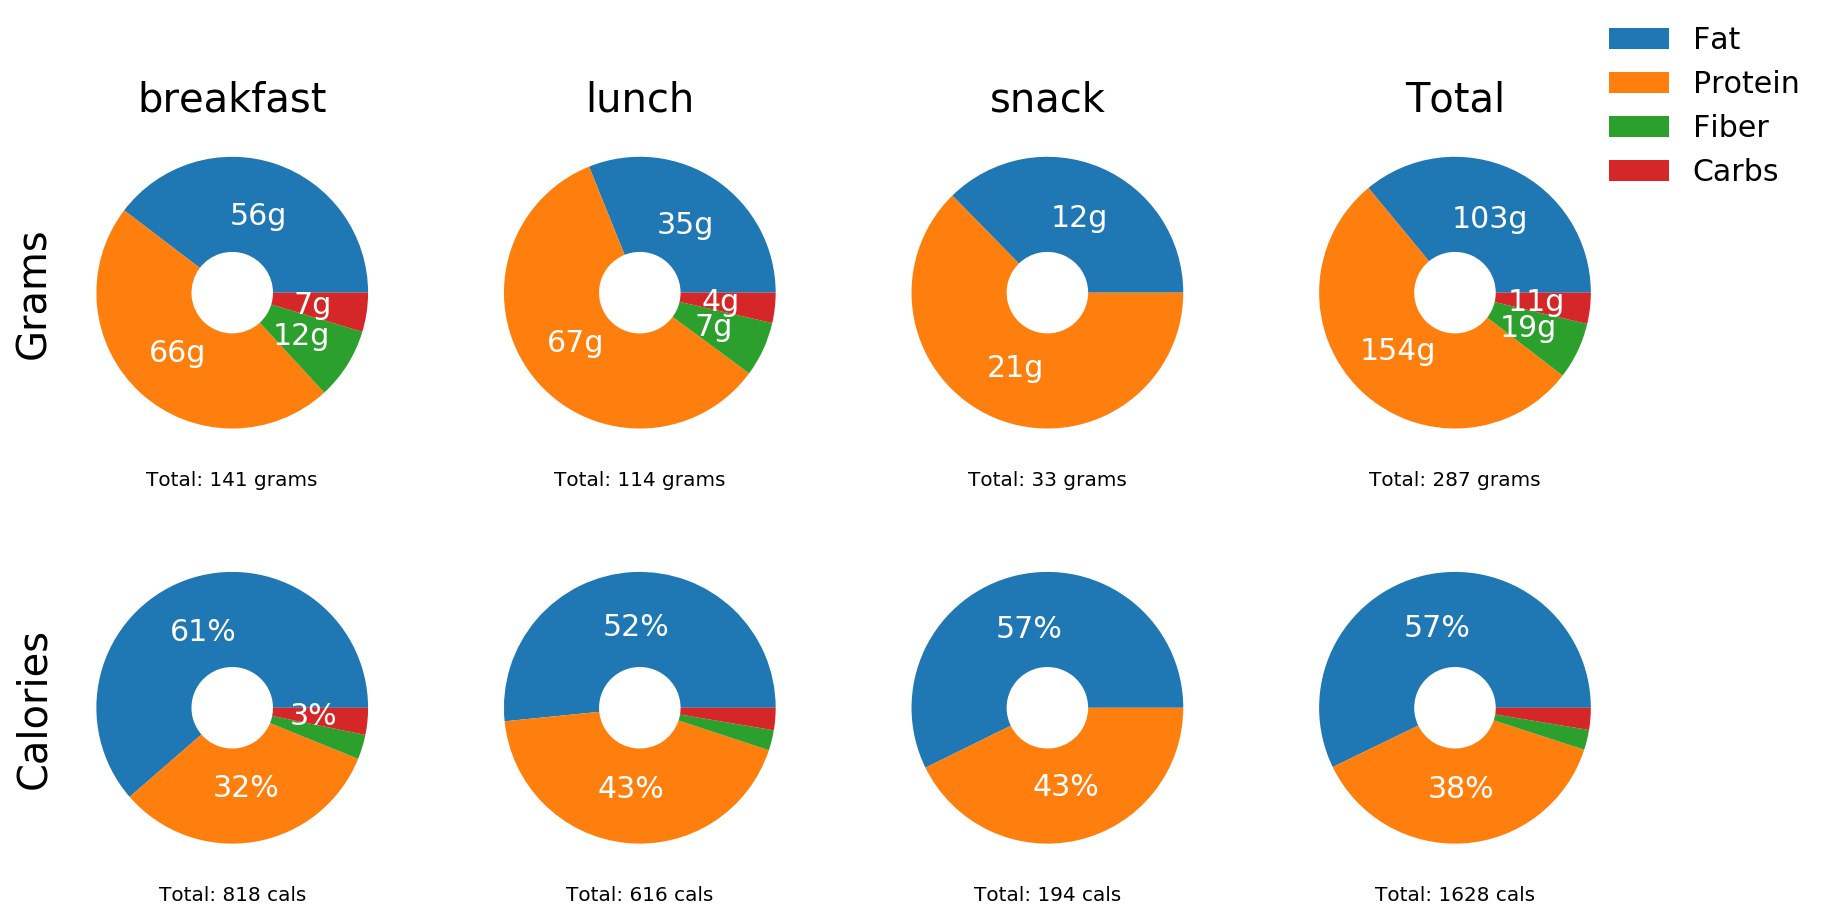

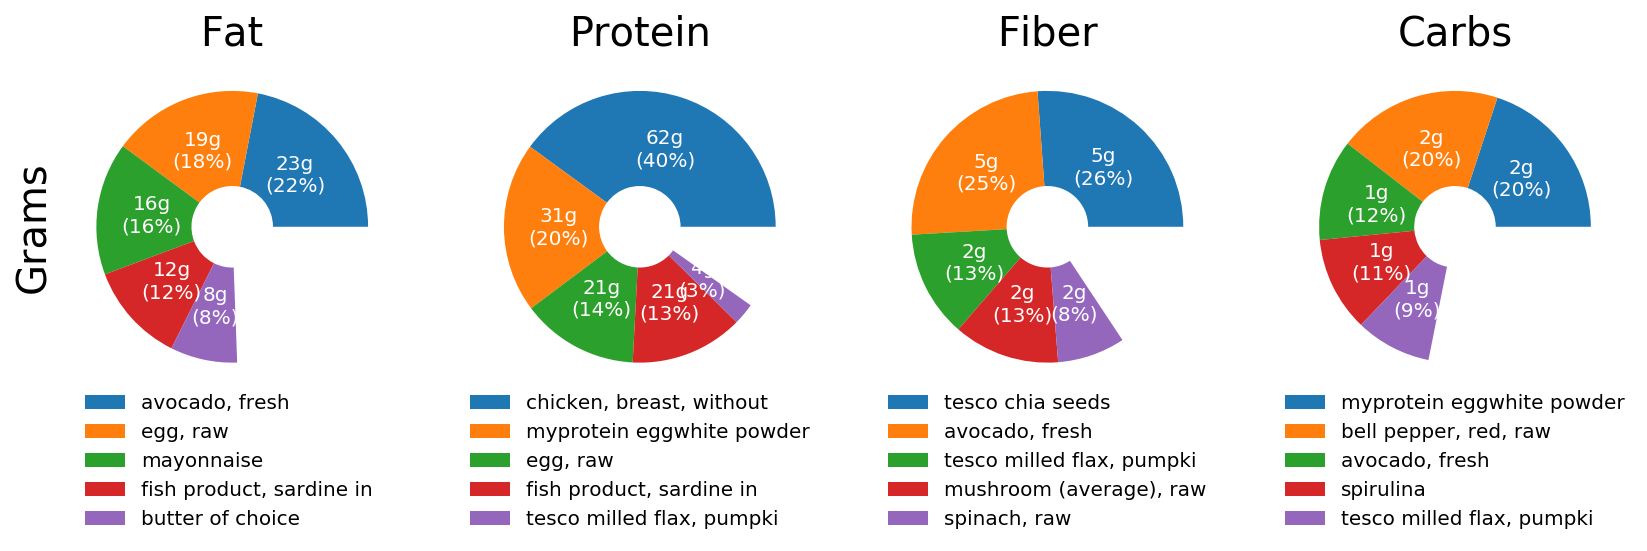

In [12]:
import meals

meal_data = make_data(meals.jan17_2021, foods)
meal_plots(meal_data)
nuts_plots(meal_data)